# Modeling Notebook with Balanced Dataset

# Importing Packages

In [25]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pickle
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sklearn import linear_model, utils, svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report,balanced_accuracy_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import nltk
from nltk.corpus import stopwords
import string

import multiprocessing
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../py")
from utils import *
from preprocess import *


In [31]:
train = pickle.load(open("../pickle/train_bal.pickle", "rb"))
val = pickle.load(open("../pickle/val_bal.pickle", "rb"))
test = pickle.load(open("../pickle/test_bal.pickle", "rb"))

In [5]:
train.head()

,tweet,target
0,@ICC you should be worried about other things ...,1
1,@amberhasalamb Can you comment on Ford doing t...,1
2,@MalcolmNance @montanaisthebes I agree with ma...,1
3,And now for the dish that best represents the ...,1
4,.@mark_kaiserr Im not sexist but every food pl...,1


In [4]:
train.target.value_counts()

0    17514
1     5268
Name: target, dtype: int64

In [6]:
val.head()

,tweet,target
0,Black cops want to kill white citizens. Spic c...,1
1,stupid loose pussyed bitch,1
2,WHAT A DUMB BITCH #MKR,1
3,@MattHancock Your Tweet hasn’t gone down very ...,1
4,Fucking Asshole! There is something really rea...,1


In [15]:
train.tweet = train.tweet.apply(lambda x: preprocess(x))
train.head()

,tweet,target
0,worry things sign patriotism gloves huh indvsaus,1
1,comment ford thing complain,1
2,agree malcolm nance pompeo bolton war monger l...,1
3,dish best represent girls big deconstruct tart...,1
4,sexist food place work girls come couple hours...,1


In [16]:
val.tweet = val.tweet.apply(lambda x: preprocess(x))
val.head()

,tweet,target
0,black cop want kill white citizens spic cop wa...,1
1,stupid loose pussyed bitch,1
2,dumb bitch mkr,1
3,tweet go matt surprise,1
4,fuck asshole wrong man,1


In [32]:
test.tweet = test.tweet.apply(lambda x: preprocess(x))
test.head()

,tweet,target
0,little girl cry parade hypocrite buy kid doll ...,1
1,hate football faggot,1
2,sexist come football idc hate girls pic hot gu...,1
3,women shouldnt rap gross notsexist,1
4,sexist evident woman man job come tennis coach...,1


# Modeling

In [17]:
X_tr = train.tweet.values
X_val = val.tweet.values
y_tr = train.target.values
y_val = val.target.values

vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(X_tr)
tfidf_val = vec.transform(X_val)

## Multinomial Naive Bayes Model

Accuracy:  0.8676761026991442
F1 Score:  0.6045901639344262
ROC-AUC:  0.9035956439614513
Recall:  0.43738140417457305
Precision:  0.9787685774946921
PR-AUC:  0.8303426892994492


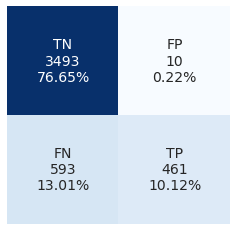

In [18]:
nb = MultinomialNB().fit(tfidf_tr, y_tr)
y_pr_nb_val = nb.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pr_nb_val, nb)

## Random Forest Classifier

Accuracy:  0.9087118718455124
F1 Score:  0.7805907172995782
ROC-AUC:  0.941597633039937
Recall:  0.7020872865275142
Precision:  0.8788598574821853
PR-AUC:  0.8818436250139308


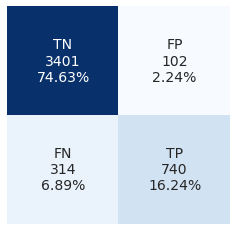

In [19]:
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(tfidf_tr, y_tr)
y_pr_rf_val = rf.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pr_rf_val, rf)

## Logistic Regression

Accuracy:  0.9082729866140005
F1 Score:  0.7723311546840959
ROC-AUC:  0.9474531453386931
Recall:  0.6726755218216319
Precision:  0.9066496163682864
PR-AUC:  0.894792154330815


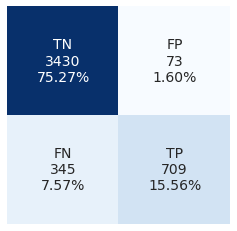

In [20]:
log = LogisticRegression(random_state=42).fit(tfidf_tr, y_tr)
y_pr_log_val = log.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pr_log_val, log)

## Support Vector Machine

In [26]:
svc = svm.LinearSVC(random_state=42).fit(tfidf_tr, y_tr)
y_pr_svc_val = svc.predict(tfidf_val)
get_metrics_2(tfidf_val, y_val, y_pr_svc_val, svc)

Accuracy:  0.9071757735352205
F1:  0.7820710973724884
Recall:  0.7201138519924098
Precision:  0.8556933483652762
ROC-AUC:  0.9428593599089097
PR-AUC:  0.8861222610027533


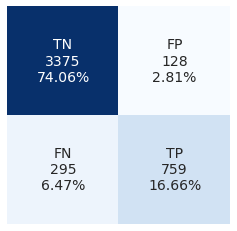

In [22]:
get_confusion(y_val, y_pr_svc_val)

## AdaBoost Classifier

Accuracy:  0.8856703971911345
F1 Score:  0.7081232492997199
ROC-AUC:  0.9347362060494637
Recall:  0.5996204933586338
Precision:  0.8645690834473324
PR-AUC:  0.8528567726698857


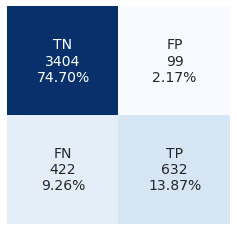

In [23]:
abc = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    random_state=42
    ).fit(tfidf_tr, y_tr)
y_pr_abc_val = abc.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pr_abc_val, abc)

## Gradient Boosting

Accuracy:  0.8775510204081632
F1 Score:  0.6445859872611466
ROC-AUC:  0.9213181870134627
Recall:  0.48007590132827327
Precision:  0.9806201550387597
PR-AUC:  0.803618724371077


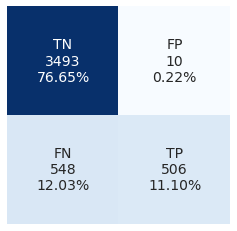

In [24]:
gbc = GradientBoostingClassifier(random_state=42).fit(tfidf_tr, y_tr)
y_pr_gbc_val = gbc.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pr_gbc_val, gbc)

## Metrics Dataframe

In [27]:
data = {'Accuracy': [accuracy(y_val, y_pr_nb_val), 
                     accuracy(y_val, y_pr_rf_val), 
                     accuracy(y_val, y_pr_log_val), 
                     accuracy(y_val, y_pr_svc_val),
                     accuracy(y_val, y_pr_abc_val),
                     accuracy(y_val, y_pr_gbc_val)],
        'F1 Score': [f1(y_val, y_pr_nb_val), 
                     f1(y_val, y_pr_rf_val), 
                     f1(y_val, y_pr_log_val), 
                     f1(y_val, y_pr_svc_val),
                     f1(y_val, y_pr_abc_val),
                     f1(y_val, y_pr_gbc_val)],
        'Recall': [recall(y_val, y_pr_nb_val), 
                   recall(y_val, y_pr_rf_val), 
                   recall(y_val, y_pr_log_val),
                   recall(y_val, y_pr_svc_val),
                   recall(y_val, y_pr_abc_val),
                   recall(y_val, y_pr_gbc_val)],
        'Precision': [precision(y_val, y_pr_nb_val), 
                      precision(y_val, y_pr_rf_val), 
                      precision(y_val, y_pr_log_val),
                      precision(y_val, y_pr_svc_val),
                      precision(y_val, y_pr_abc_val),
                      precision(y_val, y_pr_gbc_val)],
        'ROC-AUC': [auc(tfidf_val, y_val, nb),
                    auc(tfidf_val, y_val, rf),
                    auc(tfidf_val, y_val, log),
                    auc2(tfidf_val, y_val, svc),
                    auc(tfidf_val, y_val, abc),
                    auc(tfidf_val, y_val, gbc)],
        'PR AUC': [aps(tfidf_val, y_val, nb),
                   aps(tfidf_val, y_val, rf),
                   aps(tfidf_val, y_val, log),
                   aps2(tfidf_val, y_val, svc),
                   aps(tfidf_val, y_val, abc),
                   aps(tfidf_val, y_val, gbc)]}
metrics5 = pd.DataFrame(data=data, index = ['Multinomial Naive Bayes', 
                                            'Random Forest',
                                            'Logistic Regression',
                                            'Support Vector Machine', 
                                            'AdaBoost Classifier', 
                                            'Gradient Boosting Classifier'])

In [29]:
metrics5.to_csv("../data/metrics/metrics5.csv")
metrics5

,Accuracy,F1 Score,Recall,Precision,ROC-AUC,PR AUC
Multinomial Naive Bayes,0.867676,0.604590,0.437381,0.978769,0.903596,0.830343
Random Forest,0.908712,0.780591,0.702087,0.878860,0.941598,0.881844
Logistic Regression,0.908273,0.772331,0.672676,0.906650,0.947453,0.894792
Support Vector Machine,0.907176,0.782071,0.720114,0.855693,0.942859,0.886122
AdaBoost Classifier,0.885670,0.708123,0.599620,0.864569,0.934736,0.852857
Gradient Boosting Classifier,0.877551,0.644586,0.480076,0.980620,0.921318,0.803619


In [ ]:
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)


In [18]:
test = pickle.load(open("../pickle/test_bal.pickle", "rb"))
test.head()


,tweet,label
0,"[people, faggot, like, bear, way, big, douche,...",1
1,"[far, girls, team, female, team, place, major,...",1
2,"[legally, force, parenthood]",1
3,"[simple, trumpisatraitor]",1
4,"[punishment, rapists, hang, till, death, publi...",1


# Holdout Set

In [34]:
X_tt = test.tweet
y_tt = test.target
tfidf_tt = vec.transform(X_tt)


In [35]:
y_pr_nb_tt = nb.predict(tfidf_tt)
y_pr_rf_tt = rf.predict(tfidf_tt)
y_pr_log_tt = log.predict(tfidf_tt)
y_pr_svc_tt = svc.predict(tfidf_tt)
y_pr_abc_tt = abc.predict(tfidf_tt)
y_pr_gbc_tt = gbc.predict(tfidf_tt)


Accuracy:  0.8673905890095426
F1 Score:  0.6075949367088608
ROC-AUC:  0.9012150105224186
Recall:  0.4438122332859175
Precision:  0.9629629629629629
PR-AUC:  0.830637526427871


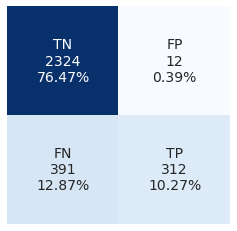

In [36]:
get_metrics_confusion(tfidf_tt, y_tt, y_pr_nb_tt, nb)

Accuracy:  0.9095097071405067
F1 Score:  0.7859922178988328
ROC-AUC:  0.9414456025058946
Recall:  0.7183499288762447
Precision:  0.8676975945017182
PR-AUC:  0.8805716403226312


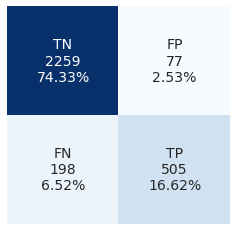

In [37]:
get_metrics_confusion(tfidf_tt, y_tt, y_pr_rf_tt, rf)

Accuracy:  0.9104968739717012
F1 Score:  0.7802907915993539
ROC-AUC:  0.9489684010795222
Recall:  0.6870554765291608
Precision:  0.902803738317757
PR-AUC:  0.8952297573692674


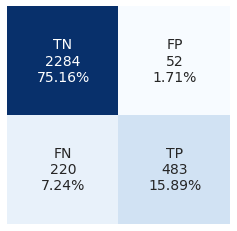

In [38]:
get_metrics_confusion(tfidf_tt, y_tt, y_pr_log_tt, log)

###

In [39]:
get_metrics_2(tfidf_tt, y_tt, y_pr_svc_tt, svc)

Accuracy:  0.9075353734781179
F1:  0.7863117870722434
Recall:  0.7354196301564723
Precision:  0.8447712418300654
ROC-AUC:  0.9443161280422454
PR-AUC:  0.8879893349123241


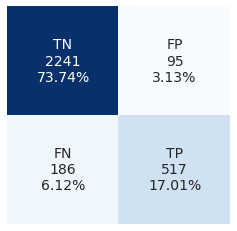

In [40]:
get_confusion(y_tt, y_pr_svc_tt)

Accuracy:  0.8845014807502468
F1 Score:  0.7091963545981773
ROC-AUC:  0.9342534563222198
Recall:  0.6088193456614509
Precision:  0.8492063492063492
PR-AUC:  0.8505129485681517


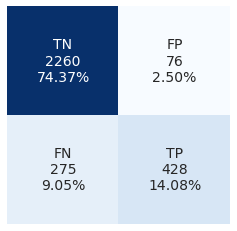

In [41]:
get_metrics_confusion(tfidf_tt, y_tt, y_pr_abc_tt, abc)

Accuracy:  0.8756169792694966
F1 Score:  0.6413662239089184
ROC-AUC:  0.9192045100255266
Recall:  0.48079658605974396
Precision:  0.9629629629629629
PR-AUC:  0.8022030120923302


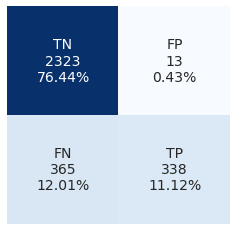

In [42]:
get_metrics_confusion(tfidf_tt, y_tt, y_pr_gbc_tt, gbc)

In [43]:
data6 = {'Accuracy': [accuracy(y_tt, y_pr_nb_tt), 
                      accuracy(y_tt, y_pr_rf_tt), 
                      accuracy(y_tt, y_pr_log_tt), 
                      accuracy(y_tt, y_pr_svc_tt),
                      accuracy(y_tt, y_pr_abc_tt),
                      accuracy(y_tt, y_pr_gbc_tt)],
        'F1 Score': [f1(y_tt, y_pr_nb_tt), 
                     f1(y_tt, y_pr_rf_tt), 
                     f1(y_tt, y_pr_log_tt), 
                     f1(y_tt, y_pr_svc_tt),
                     f1(y_tt, y_pr_abc_tt),
                     f1(y_tt, y_pr_gbc_tt)],
        'Recall': [recall(y_tt, y_pr_nb_tt), 
                   recall(y_tt, y_pr_rf_tt), 
                   recall(y_tt, y_pr_log_tt),
                   recall(y_tt, y_pr_svc_tt),
                   recall(y_tt, y_pr_abc_tt),
                   recall(y_tt, y_pr_gbc_tt)],
        'Precision': [precision(y_tt, y_pr_nb_tt), 
                      precision(y_tt, y_pr_rf_tt), 
                      precision(y_tt, y_pr_log_tt),
                      precision(y_tt, y_pr_svc_tt),
                      precision(y_tt, y_pr_abc_tt),
                      precision(y_tt, y_pr_gbc_tt)],
        'ROC-AUC': [auc(tfidf_tt, y_tt, nb),
                    auc(tfidf_tt, y_tt, rf),
                    auc(tfidf_tt, y_tt, log),
                    auc2(tfidf_tt, y_tt, svc),
                    auc(tfidf_tt, y_tt, abc),
                    auc(tfidf_tt, y_tt, gbc)],
        'PR AUC': [aps(tfidf_tt, y_tt, nb),
                   aps(tfidf_tt, y_tt, rf),
                   aps(tfidf_tt, y_tt, log),
                   aps2(tfidf_tt, y_tt, svc),
                   aps(tfidf_tt, y_tt, abc),
                   aps(tfidf_tt, y_tt, gbc)]}
metrics6 = pd.DataFrame(data=data6, index = ['Multinomial Naive Bayes', 
                                             'Random Forest',
                                             'Logistic Regression',
                                             'Support Vector Machine', 
                                             'AdaBoost Classifier', 
                                             'Gradient Boosting Classifier'])

In [45]:
metrics6.to_csv("../data/metrics/metrics6.csv")
metrics6

,Accuracy,F1 Score,Recall,Precision,ROC-AUC,PR AUC
Multinomial Naive Bayes,0.867391,0.607595,0.443812,0.962963,0.901215,0.830638
Random Forest,0.909510,0.785992,0.718350,0.867698,0.941446,0.880572
Logistic Regression,0.910497,0.780291,0.687055,0.902804,0.948968,0.895230
Support Vector Machine,0.907535,0.786312,0.735420,0.844771,0.944316,0.887989
AdaBoost Classifier,0.884501,0.709196,0.608819,0.849206,0.934253,0.850513
Gradient Boosting Classifier,0.875617,0.641366,0.480797,0.962963,0.919205,0.802203


# Hyperparameters Tuning

## Logistic Regression

In [47]:
logreg = LogisticRegression(random_state=42)
params = {'C': [0.001, 0.01, 0.1, 1, 10], 
          'penalty': ['l1', 'l2', 'elasticnet'],
          'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}
gslog = GridSearchCV(estimator = logreg,
                     param_grid = params,
                     cv = 10,
                     n_jobs = -1, 
                     verbose=3).fit(tfidf_tr, y_tr)
y_pred_gslog = gslog.predict(tfidf_val)
print("Best: %f using %s" % (gslog.best_score_, gslog.best_params_))

Fitting 10 folds for each of 75 candidates, totalling 750 fits
Best: 0.910675 using {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


Accuracy:  0.9069563309194646
F1 Score:  0.7818930041152264
ROC-AUC:  0.9448175621763075
Recall:  0.7210626185958254
Precision:  0.8539325842696629
PR-AUC:  0.8889208007196384


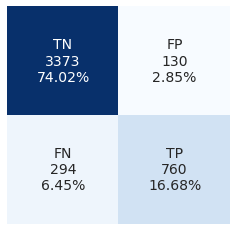

In [48]:
get_metrics_confusion(tfidf_val, y_val, y_pred_gslog, gslog)

Accuracy:  0.9069563309194646
F1 Score:  0.7818930041152264
ROC-AUC:  0.9448175621763075
Recall:  0.7210626185958254
Precision:  0.8539325842696629
PR-AUC:  0.8889208007196384


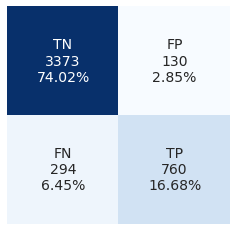

In [49]:
log_best = LogisticRegression(random_state=42, 
                              C=10, 
                              penalty='l2', 
                              solver='lbfgs').fit(tfidf_tr, y_tr)
y_pred_log_best = log_best.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pred_log_best, log_best)

## Random Forest Classifier

In [46]:
rfc = RandomForestClassifier(random_state=42)
params = {'n_estimators': [50, 100, 200, 400, 600, 800, 1000]}
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     cv = 5,
                     n_jobs = -1,
                     verbose=2).fit(tfidf_tr, y_tr)
y_pred_gsrfc = gsrfc.predict(tfidf_val)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best: 0.904793 using {'n_estimators': 1000}


In [ ]:
rfc = RandomForestClassifier(random_state=42)
params = {'n_estimators': [500, 1000, 2000, 5000]}
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     cv = 5,
                     n_jobs = -1,
                     verbose=2).fit(tfidf_tr, y_tr)
y_pred_gsrfc = gsrfc.predict(tfidf_val)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))

In [ ]:
rfc = RandomForestClassifier(random_state=42)
params = {'n_estimators': [50, 100, 200, 400, 600, 800, 1000],
          'max_depth': [10, 20, 30, 40, 50, 75, 100],
         }
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     cv = 5,
                     n_jobs = -1,
                     verbose=2).fit(tfidf_tr, y_tr)
y_pred_gsrfc = gsrfc.predict(tfidf_val)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))

In [ ]:
rfc = RandomForestClassifier(random_state=42)
params = {'n_estimators': [50, 100, 200, 400, 600, 800, 1000],
          'max_depth': [10, 20, 30, 40, 50, 75, 100],
          'min_samples_leaf': [1, 2, 4]
         }
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     cv = 5,
                     n_jobs = -1,
                     verbose=2).fit(tfidf_tr, y_tr)
y_pred_gsrfc = gsrfc.predict(tfidf_val)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))

In [ ]:
rfc = RandomForestClassifier(random_state=42)
params = {'n_estimators': [50, 100, 200, 400, 600, 800, 1000],
          'max_depth': [10, 20, 30, 40, 50, 75, 100],
          'min_samples_leaf': [1, 2, 4],
          'min_samples_split': [2, 5, 10]
         }
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     cv = 5,
                     n_jobs = -1,
                     verbose=2).fit(tfidf_tr, y_tr)
y_pred_gsrfc = gsrfc.predict(tfidf_val)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))

Accuracy:  0.6948766603415559
F1 Score:  0.16510903426791276
ROC-AUC:  0.931133569560637
Recall:  0.0899830220713073
Precision:  1.0
PR-AUC:  0.9042477324568322


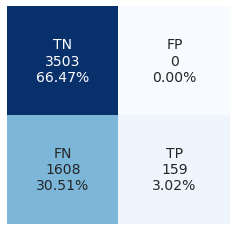

In [24]:
get_metrics_confusion(tfidf_val, y_val, y_pred_gsrfc, gsrfc)

## AdaBoost Classifier

In [30]:
abc = AdaBoostClassifier(random_state=42)
params = {'n_estimators': [10, 50, 100, 200],
          'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5]}
gsabc = GridSearchCV(estimator = abc,
                     param_grid = params,
                     n_jobs = -1,
                     cv = 5,
                     verbose = 3).fit(tfidf_tr, y_tr)
y_pred_gsabc = gsabc.predict(tfidf_val)
print("Best: %f using %s" % (gsabc.best_score_, gsabc.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best: 0.889458 using {'learning_rate': 0.5, 'n_estimators': 200}


Accuracy:  0.8943074003795066
F1 Score:  0.8206119162640902
ROC-AUC:  0.9636406727776871
Recall:  0.7209960384833051
Precision:  0.9521674140508222
PR-AUC:  0.9364912980956259


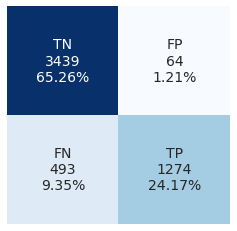

In [33]:
get_metrics_confusion(tfidf_val, y_val, y_pred_gsabc, gsabc)

Accuracy:  0.8943074003795066
F1 Score:  0.8206119162640902
ROC-AUC:  0.9636406727776871
Recall:  0.7209960384833051
Precision:  0.9521674140508222
PR-AUC:  0.9364912980956259


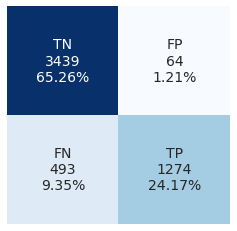

In [26]:
abc_best = AdaBoostClassifier(random_state=42, 
                              learning_rate=0.5, 
                              n_estimators=200).fit(tfidf_tr, y_tr)
y_pred_abc_best = abc_best.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pred_abc_best, abc_best)

In [ ]:
               'gamma': [0.1, 1, 10, 100, 1000],
               'kernel': ['linear', 'rbf', 'poly']

## Support Vector Machine

In [13]:
from sklearn.svm import SVC
svm = SVC()
params_grid = {'C': [0.1, 1, 10, 100, 1000]} 
gssvm = GridSearchCV(SVC(), 
                     params_grid, 
                     refit = True, 
                     verbose = 1)
gssvm.fit(tfidf_tr, y_tr)
y_pred_gssvm = gssvm.predict(tfidf_val)  
print("Best: %f using %s" % (gssvm.best_score_, gssvm.best_params_))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  30.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  30.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  31.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  40.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  37.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  34.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  35.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  33.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  33.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  33.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  33.1s
[CV] END ......................C=0.1, gamma=0.0

In [15]:
get_metrics_2(tfidf_val, y_val, y_pred_gssvm, gssvm)

Accuracy:  0.9318785578747628
F1:  0.8936926265916494
Recall:  0.8539898132427843
Precision:  0.9372670807453416
PR-AUC:  0.9541107966458856


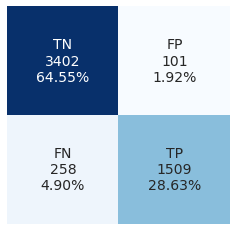

In [17]:
get_confusion(y_val, y_pred_gssvm)

Accuracy:  0.9318785578747628
F1:  0.8936926265916494
Recall:  0.8539898132427843
Precision:  0.9372670807453416
PR-AUC:  0.9541107966458856


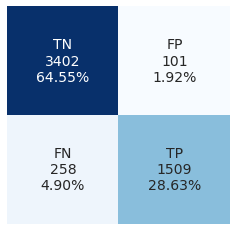

In [19]:
svm_best = SVC(C=1, gamma=1, kernel='rbf').fit(tfidf_tr, y_tr)
y_pred_svm_best = svm_best.predict(tfidf_val)
get_metrics_2(tfidf_val, y_val, y_pred_svm_best, svm_best)
get_confusion(y_val, y_pred_svm_best)

In [20]:
import pickle
with open('../pickle/best_model.pickle', 'wb') as f:
    pickle.dump(svm_best, f, pickle.HIGHEST_PROTOCOL)

In [27]:
data7 = {'Accuracy': [accuracy(y_val, y_pred_log_best), 
                      accuracy(y_val, y_pred_gsrfc), 
                      accuracy(y_val, y_pred_abc_best), 
                      accuracy(y_val, y_pred_svm_best)],
        'F1 Score': [f1(y_val, y_pred_log_best), 
                     f1(y_val, y_pred_gsrfc), 
                     f1(y_val, y_pred_abc_best), 
                     f1(y_val, y_pred_svm_best)],
        'Recall': [recall(y_val, y_pred_log_best), 
                   recall(y_val, y_pred_gsrfc), 
                   recall(y_val, y_pred_abc_best),
                   recall(y_val, y_pred_svm_best)],
        'Precision': [precision(y_val, y_pred_log_best), 
                      precision(y_val, y_pred_gsrfc), 
                      precision(y_val, y_pred_abc_best),
                      precision(y_val, y_pred_svm_best)],
        'ROC-AUC': [auc(tfidf_val, y_val, log_best),
                    auc(tfidf_val, y_val, gsrfc),
                    auc(tfidf_val, y_val, abc_best),
                    auc2(tfidf_val, y_val, svm_best)],
        'PR AUC': [aps(tfidf_val, y_val, log_best),
                   aps(tfidf_val, y_val, gsrfc),
                   aps(tfidf_val, y_val, abc_best),
                   aps2(tfidf_val, y_val, svm_best)]}
metrics7 = pd.DataFrame(data=data7, index = ['Logistic Regression w/GridsearchCV', 
                                             'Random Forest w/GridsearchCV',
                                             'AdaBoost Classifier w/GridsearchCV',
                                             'Support Vector Machine w/GridsearchCV'])

In [28]:
metrics7

,Accuracy,F1 Score,Recall,Precision,ROC-AUC,PR AUC
Logistic Regression w/GridsearchCV,0.924099,0.881517,0.842105,0.924798,0.965593,0.955385
Random Forest w/GridsearchCV,0.694877,0.165109,0.089983,1.000000,0.931134,0.904248
AdaBoost Classifier w/GridsearchCV,0.894307,0.820612,0.720996,0.952167,0.963641,0.936491
Support Vector Machine w/GridsearchCV,0.931879,0.893693,0.853990,0.937267,0.965325,0.954111


In [29]:
metrics7.to_csv("../data/metrics/metrics7.csv")

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features':
}

}